# Simulate the data

This notebook contains the code to simulate the data for the experiments. 

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import linalg
from sklearn.metrics import r2_score

In [2]:
# load the settings that we store externally
config = json.load(open('settings.json'))
N_responses = config['N_responses']
rater_rhos = config['rater_rhos']
n_raters = config['n_raters']
n_systems = config['n_systems']
score_range = config['score_range']

In [3]:
# We first generate true/golden standard score with a given distribution
# We also truncate the scores to score range.
np.random.seed(100)
true_scores = np.random.normal(config['true_score_mean'], config['true_score_sd'], N_responses)
true_scores = np.where(true_scores >= score_range[1], score_range[1],
                      np.where(true_scores <= score_range[0], score_range[0],
                      true_scores))

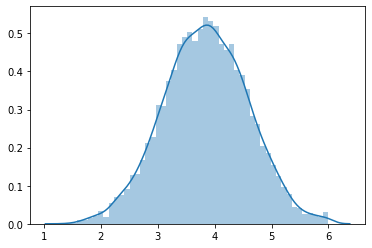

In [4]:
# let's check their distribution to make sure it looks as expected.
sns.distplot(true_scores)

We now want to generate human scores which will be generated as np.round(true_score + error). We are going to generate several categories of raters with pre-determined correlation within each group. The error is sampled from the normal distribution with mean = 0 and sd = error_sd. We are going to empirically figure out what error_sd gives us an expected correlation.

In [5]:
def get_rater_score(true_score, error_sd, seed):
    '''
    Compute discrte rater score using true scores and a given errror
    '''
    np.random.seed(seed)
    rater_error = np.random.normal(0, error_sd, N_responses)
    rater_round = rater = np.round(true_score + rater_error)
    rater_truncated = pd.Series(np.where(rater > score_range[1], score_range[1],
                                np.where(rater < score_range[0], score_range[0],
                                rater)))
    return rater_truncated

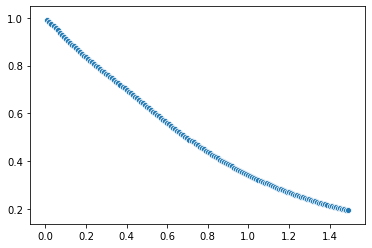

In [6]:
# Look at relationship between the error and the correlation between raters
corrs = []
errors = np.arange(0.01, 1.5, step=0.01)
seed = 100
for error_sd in errors:
    raters = []
    for i in range(0, 50):
        rater = get_rater_score(true_scores, error_sd, seed + i*25)
        raters.append(rater)
    df_raters = pd.concat(raters, axis=1)
    corr_error = df_raters.corr().values
    mean_corr = corr_error[corr_error != 1].mean()
    corrs.append(mean_corr)
sns.scatterplot(x=errors, y=corrs)   

In [9]:
# now get the error corresponding to the desired rho in our configuration file
human_errors = []
for rho in rater_rhos:
    i = (np.abs(np.array(corrs)-rho)).argmin()
    error_sd = errors[i]
    print("Expected inter-rater rho: {}, simulated rho: {}, Error sd: {}".format(rho, corrs[i], error_sd))
    human_errors.append(error_sd)

Expected inter-rater rho: 0.4, simulated rho: 0.4016214794913189, Error sd: 0.87
Expected inter-rater rho: 0.55, simulated rho: 0.546943780912957, Error sd: 0.62
Expected inter-rater rho: 0.65, simulated rho: 0.6491138881877759, Error sd: 0.47000000000000003
Expected inter-rater rho: 0.8, simulated rho: 0.7991382675357793, Error sd: 0.25


In [10]:
### Now simulate the data we will use for our experiments

df = pd.DataFrame({'id': ['id_{}'.format(i) for i in range(N_responses)],
                  'true': true_scores})

# First simulate the human raters using the rater errors that we identified at previous step
raters = []
rater_index = 1 # we start index from 1 because it makes it easier later to aggregate scores across multiple raters.

seed = 232626
for i in range(len(n_raters)):
    error_sd = human_errors[i]
    for j in range(0, n_raters[i]):
        rater_name = 'h_{}'.format(rater_index)
        rater_scores = get_rater_score(true_scores, error_sd, seed + j*23532)
        df[rater_name] = rater_scores
        df_rater = pd.DataFrame({'rater_id': [rater_name],
                                'error_sd': error_sd,
                                'category': config['rater_categories'][i],
                                'expected_rho': config['rater_rhos'][i]})
        raters.append(df_rater)
        rater_index +=1

df_raters = pd.concat(raters)

# Now simulate system score. Since we already pre-defined expected R2 with true 
# scores in our config file, we compute the standard deviation used to sample the error
# by taking advantage of the 
# fact that R2 = 1 - Var(MSE)/Var(True)

systems = []
system_index = 1

seed = 726262
for i in range(0, len(n_systems)):
    system_r2 = config['system_r2'][i]
    error = np.sqrt(np.var(true_scores) * (1 - system_r2))
    for j in range(0, n_systems[i]):
        system_name = 'sys_{}'.format(system_index) 
        np.random.seed(seed + j*3426)
        system_error = np.random.normal(0, error, N_responses)
        df[system_name] = true_scores + system_error
        df_system = pd.DataFrame({'system_id': [system_name],
                                  'exp_r2_true': config['system_r2'][i]})
        systems.append(df_system)
        system_index += 1

df_systems = pd.concat(systems)

# Check human score correlations

Finally, we do several sanity checks to make sure everything worked as expected and create descriptive analyses for the paper. 

In [11]:
# let's identify columns with human scores
human_scores = df_raters['rater_id'].values

In [12]:
# First we check that the correlations within each group are approximately what we wanted them to be.

human_corr = df[human_scores].corr().unstack().reset_index()
human_corr.columns = ['r1', 'r2', 'corr']
# exclude correlation between the scores from the same rater
human_corr = human_corr[human_corr['r1'] != human_corr['r2']]
df_with_category = pd.merge(human_corr, df_raters, left_on ='r1', right_on='rater_id')
df_with_category = pd.merge(df_with_category, df_raters, left_on='r2', right_on='rater_id', 
                           suffixes = ['_r1', '_r2'])
df_with_category['same_group'] = np.where(df_with_category['category_r1'] == df_with_category['category_r2'],
                                         'yes', 'no')
print("Expected correlations:", rater_rhos)
print("Simulated correlations:")
df_with_category.groupby(['category_r1', 'category_r2'])['corr'].mean().unstack().loc[config['rater_categories'],
                                                                                      config['rater_categories']]

Expected correlations: [0.4, 0.55, 0.65, 0.8]
Simulated correlations:


category_r2,low,moderate,average,high
category_r1,,,,
low,0.394381,0.470978,0.511361,0.562844
moderate,0.470978,0.540528,0.597002,0.657783
average,0.511361,0.597002,0.644031,0.717764
high,0.562844,0.657783,0.717764,0.797603


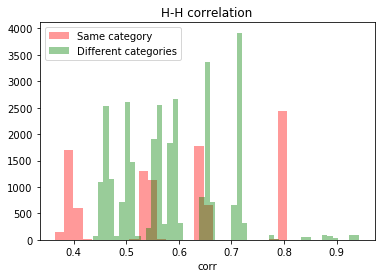

In [13]:
# Distribution of correlations within and across groups

df_same_group = df_with_category[df_with_category['same_group']=='yes'].groupby('category_r1')['corr'].mean()
sns.distplot(df_with_category[df_with_category['same_group']=='yes']['corr'],
            color="red", label="Same category", kde=False)
sns.distplot(df_with_category[df_with_category['same_group']=='no']['corr'],
            color="green", label="Different categories", kde=False)
plt.title("H-H correlation")
plt.legend()

In [14]:
# create the table for the paper showing descriptive stats for each group

df_human = df[human_scores].melt(var_name='rater_id', value_name='score')
df_h_with_category = pd.merge(df_human, df_raters)

In [15]:
df_desc = df_h_with_category.groupby('category')['score'].describe()[['mean', 'std']]
df_desc_with_corr = pd.concat([df_desc, df_same_group], axis=1)
#df_desc_with_corr['count'] = df_desc_with_corr['count'].astype(int)
df_desc_with_corr['N raters'] = config['n_raters']
cols_for_table = ['N raters', 'corr', 'mean', 'std']
print(df_desc_with_corr.loc[config['rater_categories'], cols_for_table].to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
{} &  N raters &  corr &  mean &  std \\
\midrule
low      &        50 &  0.39 &  3.83 & 1.15 \\
moderate &        50 &  0.54 &  3.84 & 1.00 \\
average  &        50 &  0.64 &  3.84 & 0.92 \\
high     &        50 &  0.80 &  3.84 & 0.84 \\
\bottomrule
\end{tabular}



## Now look at system scores

In [16]:
df_system_corr = df.corr().unstack().reset_index()
df_system_corr.columns = ['system', 'reference', 'corr']
df_system_corr = df_system_corr[df_system_corr['system'].isin(df_systems['system_id'])]

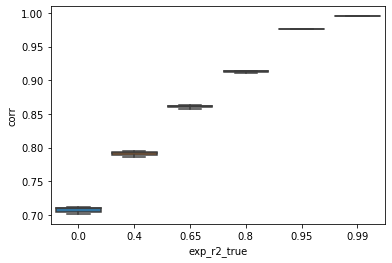

In [17]:
# correlation with true score
df_system_true = df_system_corr[df_system_corr['reference']=='true']
df_true_with_cat = pd.merge(df_system_true, df_systems, left_on='system', right_on='system_id')
sns.boxplot(x='exp_r2_true', y='corr', data=df_true_with_cat)

In [18]:
# Mean correlations between systems in different groups and different categories of raters

df_system_corr_with_category = pd.merge(df_system_corr, df_raters, left_on='reference', right_on='rater_id')
df_sys_human = pd.merge(df_system_corr_with_category, df_systems, left_on='system', right_on='system_id')
df_sys_human.groupby(['category', 'exp_r2_true'])['corr'].mean().unstack().loc[config['rater_categories']]

exp_r2_true,0.0,0.4,0.65,0.8,0.95,0.99
category,,,,,,
low,0.444385,0.496658,0.540538,0.573209,0.612636,0.624600
moderate,0.520375,0.581601,0.632997,0.671267,0.717456,0.731476
average,0.568193,0.635024,0.691123,0.732892,0.783295,0.798588
high,0.629892,0.703981,0.766173,0.812477,0.868355,0.885310


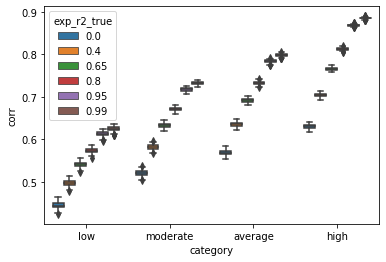

In [19]:
sns.boxplot(x='category', y='corr', hue='exp_r2_true', data=df_sys_human)

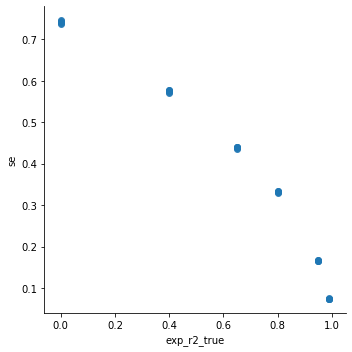

In [20]:
# rmse with true score
df_long = df.melt(id_vars = ['true'],
                 value_vars = df_systems['system_id'].values,
                 var_name = 'system_id',
                 value_name = 'score')
df_long['se'] = (df_long['score'] - df_long['true'])**2
df_by_system = df_long.groupby('system_id')['se'].apply(lambda x: np.sqrt(np.mean(x))).reset_index()
df_long_with_mse = pd.merge(df_by_system, df_systems)
sns.lmplot(x='exp_r2_true', y='se', data=df_long_with_mse, fit_reg=False)

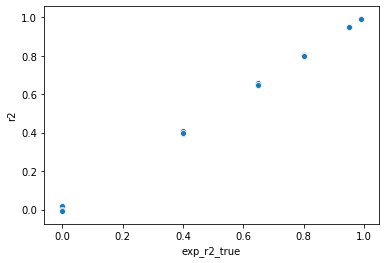

In [21]:
# r2 with true score
df_r2 = df_long.groupby('system_id').apply(lambda x: r2_score(x['true'], x['score'])).reset_index()
df_r2.columns = ['system_id', 'r2']
df_r2_with_mse = pd.merge(df_r2, df_systems)
sns.scatterplot(x='exp_r2_true', y='r2', data=df_r2_with_mse)

In [22]:
# create a table for the paper

tab_r2 = df_r2_with_mse.groupby('exp_r2_true')['r2'].mean()
tab_rmse = df_long_with_mse.groupby('exp_r2_true')['se'].mean()
tab_corr_average = df_sys_human.groupby(['category', 'exp_r2_true'])['corr'].mean().unstack().loc['average'].transpose()
tab_corr_true = df_true_with_cat.groupby('exp_r2_true')['corr'].mean()
tab_res = pd.concat([tab_r2, tab_rmse, tab_corr_average, tab_corr_true], axis=1)
tab_res.columns = ['Observed R2', 'RMSE (true)', "r with `average` raters", 'r (true)']
tab_res['N systems'] = config['n_systems']
print(tab_res[['N systems', 'RMSE (true)',  'r (true)', "r with `average` raters"]].to_latex(float_format='%.2f'))

\begin{tabular}{lrrrr}
\toprule
{} &  N systems &  RMSE (true) &  r (true) &  r with `average` raters \\
exp\_r2\_true &            &              &           &                          \\
\midrule
0.00        &          5 &         0.74 &      0.71 &                     0.57 \\
0.40        &          5 &         0.57 &      0.79 &                     0.64 \\
0.65        &          5 &         0.44 &      0.86 &                     0.69 \\
0.80        &          5 &         0.33 &      0.91 &                     0.73 \\
0.95        &          5 &         0.17 &      0.98 &                     0.78 \\
0.99        &          5 &         0.07 &      1.00 &                     0.80 \\
\bottomrule
\end{tabular}



In [23]:
df.to_csv('../data/data.csv', index=False)
df_raters.to_csv('../data/raters.csv', index=False)
df_systems.to_csv('../data/systems.csv', index=False)